In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from time import time
import pickle

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
df.head()

,headline,label
0,cock suck before you piss around on my work,-1
1,you are gay or antisemmitian archangel white ...,-1
2,fuck your filthy mother in the ass dry,-1
3,get fuck ed up get fuck ed up got a drink t...,-1
4,stupid peace of shit stop deleting my stuff ...,-1


In [4]:
df['label'].unique()

array([-1,  0])

In [5]:
#Dataframe Manipulation
def perform_data_manipulation():
    df = pd.read_csv("dataset.csv")

    for index in df.index:
        if df.loc[index, "label"]==-1:
            df.loc[index,"label"] = 1
    return df

In [6]:
df = perform_data_manipulation()

In [7]:
df.head()

,headline,label
0,cock suck before you piss around on my work,1
1,you are gay or antisemmitian archangel white ...,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1


In [8]:
def performdatadistribution(df):
    total = df.shape[0]
    num_non_toxic = df[df['label']==0].shape[0]

    slices = [num_non_toxic/total, (total-num_non_toxic)/total]
    labeling = ['Non-Toxic', 'Toxic']
    explode = [0.2, 0]

    plt.pie(slices, explode=explode, shadow=True, autopct="%1.1f%%", 
            labels=labeling, wedgeprops={'edgecolor': 'black'})
    plt.show()

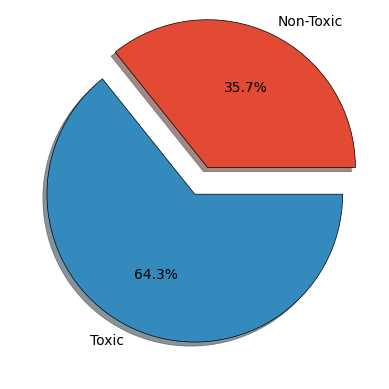

In [9]:
performdatadistribution(df)

In [10]:
def remove_pattern(input_txt, pattern):
    if (type(input_txt)==str):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)
        return input_txt
    else:
        return ""

In [11]:
df.head(1)

,headline,label
0,cock suck before you piss around on my work,1


In [12]:
def datasetCleaning(df):
    # SSL fix for NLTK download
    import ssl
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context
    nltk.download('wordnet', quiet=True)

    df['length_headline'] = df['headline'].str.len()
    combined_df = pd.concat([df, df], ignore_index=True)
    
    combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['headline'], "@[\w]*")
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(
        lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
    
    combined_df['length_tidy_tweet'] = combined_df['tidy_tweet'].str.len()
    tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x: x.split())
    
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokenized_tweet = tokenized_tweet.apply(
        lambda x: [lemmatizer.lemmatize(i) for i in x])
    
    combined_df['tidy_tweet'] = tokenized_tweet.apply(' '.join)
    return combined_df, df

In [13]:
combined_df, df= datasetCleaning(df)

In [14]:
combined_df.head()


,headline,label,length_headline,tidy_tweet,length_tidy_tweet
0,cock suck before you piss around on my work,1,44,cock suck before piss around work,33
1,you are gay or antisemmitian archangel white ...,1,624,antisemmitian archangel white tiger meow greet...,400
2,fuck your filthy mother in the ass dry,1,39,fuck your filthy mother,23
3,get fuck ed up get fuck ed up got a drink t...,1,121,fuck fuck drink that cant down fuck fuck fuck ...,51
4,stupid peace of shit stop deleting my stuff ...,1,93,stupid peace shit stop deleting stuff hole fal...,57


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier


In [21]:
def performdatasplit(x, y, combined_df, df):
    X_train, X_test, y_train, y_test = train_test_split(combined_df['tidy_tweet'], combined_df['label'], test_size = x, random_state = y)
    print(f"Number of rows in the total dataset: {combined_df.shape[0]}")
    print(f"Number of rows in the train dataset: {X_train.shape[0]}")
    print(f"Number of rows in the test dataset: {X_test.shape[0]}")
    
    files = open("stopwords.txt" , "r")
    content = files.read()
    content_list = content.split("\n")
    files.close()
    
    tfidfvector = TfidfVectorizer(stop_words=content_list, lowercase=True)
    
    training_data = tfidfvector.fit_transform(X_train.values.astype('U'))
    
    testing_data = tfidfvector.transform(X_test.values.astype('U'))
    
    filename = 'tfidfvectoizer.pkl'
    
    pickle.dump(tfidfvector.vocabulary_, open(filename, 'wb'))
    
    return X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list

In [22]:
X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list = performdatasplit(0.2, 42, combined_df, df)

Number of rows in the total dataset: 36296
Number of rows in the train dataset: 29036
Number of rows in the test dataset: 7260


In [23]:
def pipeline(X_train, y_train, X_test, y_test):
    MODELS = [LinearSVC(), LogisticRegression(), MultinomialNB(), DecisionTreeClassifier(),
              AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]
    
    size = len(y_train)
    
    results = {}
    
    final_result = []
    
    for model in MODELS:
        results['Algorithm'] = model.__class__.__name__
        
        start = time()
        print(f"Training Time : {model.__class__.__name__}")
        model.fit(X_train, y_train)
        end = time()
        
        filename = model.__class__.__name__+".pkl"
        pickle.dump(model, open(filename, "wb"))
        
        results['Training Time'] = end - start
        
        start = time()
        prediction_test = model.predict(X_test)
        prediction_train = model.predict(X_train)
        end = time()
        
        results['Prediction Time'] = end - start
        
        results['Accuracy : Test'] = accuracy_score(y_test, prediction_test)
        results['Accuracy : Train'] = accuracy_score(y_train, prediction_train)
        
        results['F1 Score : Test'] = f1_score(y_test, prediction_test)
        results['F1 Score : Train'] = f1_score(y_train, prediction_train)
        
        results['Precision : Test'] = precision_score(y_test, prediction_test)
        results['Precision : Train'] = precision_score(y_train, prediction_train)
        
        results['Recall : Test'] = recall_score(y_test, prediction_test)
        results['Recall : Train'] = recall_score(y_train, prediction_train)
        
        print(f"Training {model.__class__.__name__} finished in {results['Training Time']} sec")
        
        final_result.append(results.copy())
    return final_result
    

In [24]:
final_result = pipeline(training_data, y_train, testing_data, y_test)

Training Time : LinearSVC
Training LinearSVC finished in 0.3099038600921631 sec
Training Time : LogisticRegression
Training LogisticRegression finished in 0.36504173278808594 sec
Training Time : MultinomialNB
Training MultinomialNB finished in 0.01328587532043457 sec
Training Time : DecisionTreeClassifier
Training DecisionTreeClassifier finished in 6.518229961395264 sec
Training Time : AdaBoostClassifier
Training AdaBoostClassifier finished in 4.914675951004028 sec
Training Time : BaggingClassifier
Training BaggingClassifier finished in 94.01867699623108 sec
Training Time : SGDClassifier
Training SGDClassifier finished in 0.07664680480957031 sec


In [25]:
def performfinalresult(final_results):
    results = pd.DataFrame(final_results)
    results.reindex(columns = ['Algorithm' , 'Accuracy : Test', 'Precision : Test' , 'Recall : Test' , 'F1 Score : Test' , 'Prediction Time',
                                'Accuracy : Train' , 'Precision : Train' , ' Recall : Train' , 'F1 Score : Train' , 'Training Time'])
    results.sort_values(by = 'F1 Score : Test' , inplace = True , ascending=False)
    return results

In [32]:
results = performfinalresult(final_result)
results.reset_index(drop=True)

,Algorithm,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
0,DecisionTreeClassifier,6.518230,0.044242,0.973829,0.996832,0.979932,0.997534,0.971518,0.996146,0.988494,0.998926
1,BaggingClassifier,94.018677,0.506179,0.969559,0.995144,0.976527,0.996220,0.973528,0.995126,0.979544,0.997316
2,LinearSVC,0.309904,0.002669,0.964738,0.989048,0.972690,0.991459,0.973937,0.992152,0.971447,0.990767
3,LogisticRegression,0.365042,0.003772,0.936364,0.961152,0.950514,0.969637,0.955632,0.972464,0.945451,0.966826
4,SGDClassifier,0.076647,0.002820,0.935537,0.957845,0.949602,0.966939,0.959939,0.973142,0.939484,0.960814
5,MultinomialNB,0.013286,0.004795,0.899174,0.927676,0.925428,0.945438,0.886590,0.916159,0.967824,0.976649
6,AdaBoostClassifier,4.914676,1.380379,0.767355,0.765705,0.842606,0.840339,0.748758,0.746580,0.963350,0.961029


In [33]:
results.describe().loc[['min','max'], :]

,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
min,0.013286,0.002669,0.767355,0.765705,0.842606,0.840339,0.748758,0.746580,0.939484,0.960814
max,94.018677,1.380379,0.973829,0.996832,0.979932,0.997534,0.973937,0.996146,0.988494,0.998926


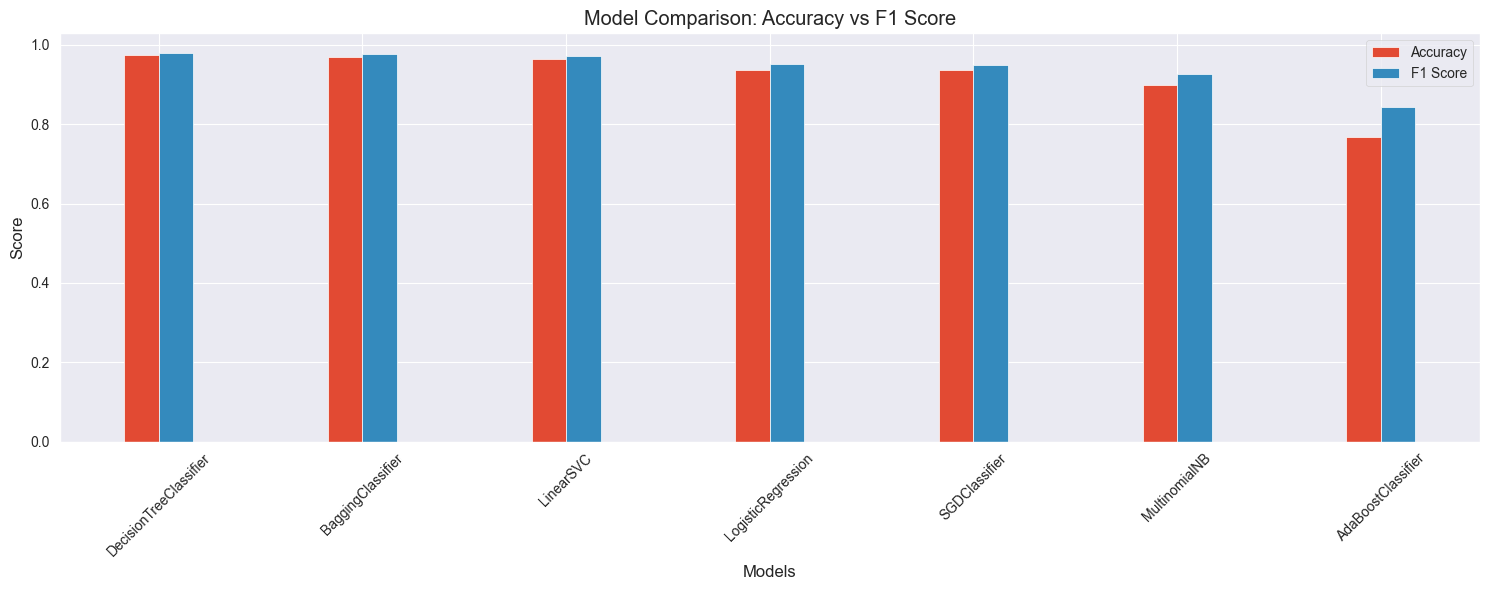

In [35]:
# Find best models by metrics
best_acc = results[results['Accuracy : Test'] == results['Accuracy : Test'].max()]
best_f1 = results[results['F1 Score : Test'] == results['F1 Score : Test'].max()]
best_precision = results[results['Precision : Test'] == results['Precision : Test'].max()]
best_recall = results[results['Recall : Test'] == results['Recall : Test'].max()]

# Plot settings
sns.set_style('darkgrid')
plt.figure(figsize=(15, 6))
barWidth = 0.17

# Bar heights
bars1 = results['Accuracy : Test']
bars2 = results['F1 Score : Test']

# Bar positions
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Colors
pal = sns.color_palette()

# Plot bars
plt.bar(r1, bars1, color=pal[0], width=barWidth, edgecolor='white', label='Accuracy')
plt.bar(r2, bars2, color=pal[1], width=barWidth, edgecolor='white', label='F1 Score')

# X-tick labels in the center of grouped bars
plt.xticks([r + barWidth / 2 for r in range(len(bars1))], results['Algorithm'], rotation=45)

# Add legend and labels
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy vs F1 Score')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

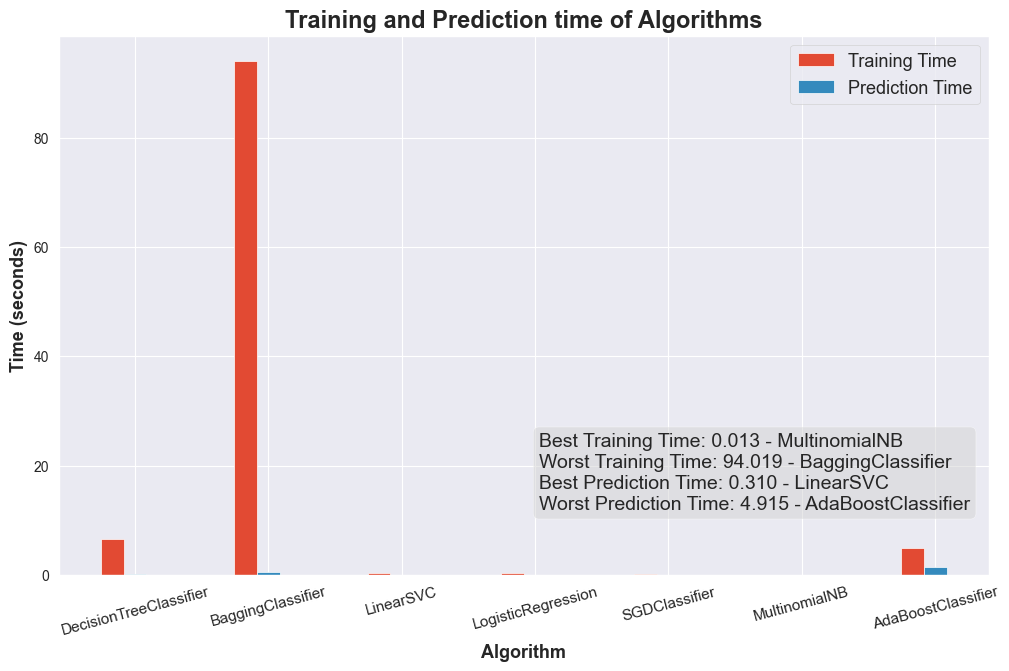

In [36]:
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [37]:
df.head()


,headline,label,length_headline
0,cock suck before you piss around on my work,1,44
1,you are gay or antisemmitian archangel white ...,1,624
2,fuck your filthy mother in the ass dry,1,39
3,get fuck ed up get fuck ed up got a drink t...,1,121
4,stupid peace of shit stop deleting my stuff ...,1,93


In [38]:
data = ["You are so beautiful"]

tfidf_vector = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("tfidfvectoizer.pkl", "rb")))
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open('LinearSVC.pkl', 'rb'))
print(trained_model.predict(preprocessed_data))

if(trained_model.predict(preprocessed_data)==1):
    print("bulling")
else:
    print("non-bulling")

[0]
non-bulling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


In [39]:
from sklearn.model_selection import GridSearchCV

def tuining(clf, param_dict, X_train, y_train, X_test, y_test):
    scorer = make_scorer(f1_score)
    
    grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=5)
    
    grid_fit = grid_obj.fit(X_train, y_train)
    
    best_clf = grid_fit.best_estimator_
    
    prediction = (clf.fit(X_train, y_train)).predict(X_test)
    
    best_prediction = best_clf.predict(X_test)
    
    print(clf.__class__.__name__)
    print(f"Best Parameter:  {grid_fit.best_params_}")
    
    print(f"Accuracy:  {accuracy_score(y_test, best_prediction)}")

    print(f"F1 Score :  {f1_score(y_test, best_prediction)}")
    
    print(f"Precision :  {precision_score(y_test, best_prediction)}")
    
    print(f"Recall:  {recall_score(y_test, best_prediction)}")

In [40]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_model = LinearSVC()

tuining(clf_model, param_grid, training_data, y_train, testing_data, y_test)

LinearSVC
Best Parameter:  {'C': 1}
Accuracy:  0.9647382920110192
F1 Score :  0.9726904203114999
Precision :  0.9739371929074984
Recall:  0.9714468357127637


In [41]:
pickle.dump(clf_model, open("LinearSVCTuned.pkl", "wb"))
